<p style="font-size:30px; text-align:center"><b>Heston model</b></p>
We review the Heston model. The results are presented using the Python data science stack.

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib notebook

In [2]:
from copy import deepcopy
import itertools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
import ipywidgets as wd
import pickle
from statsmodels.distributions.empirical_distribution import ECDF

import sys
sys.path.append("../../")
import pyqfin.models.heston as h

# Dynamics of the Underlying

We consider the Heston stochastic volatility model, which assumes that the stock price process $S_t$ and its stochastic variance process $V_t$ are modelled on a probability space $(\Omega, \mathcal{F}, \mathcal{P})$ and follow the dynamics
\begin{align}
    dS_t &= (r-q)S_t dt + \sqrt{V_t} S_t dW_t, && S_0 = s_0 \\
    dV_t &= \kappa(\vartheta - V_t) dt + \sigma \sqrt{V_t} dZ_t, && V_0 = v_0,
\end{align}
where
* $s_0 \in \mathbb{R}$ is the initial value for the stock,
* $v_0 \in \mathbb{R}_{>0}$ is the initial value for the volatility,
* $\kappa \in \mathbb{R}$ is the mean reversion rate of the volatility,
* $\vartheta \in \mathbb{R}_{>0}$ is the long-term mean of the volatility,
* $\sigma \in \mathbb{R}_{>0}$ is the volatility of the volatility,
* $\rho \in [-1, 1]$ is the assumed correlation between the Brownian motions $W_t$ and $Z_t$.
* $r \in \mathbb{R}$ is the risk-free rate,
* $q \in \mathbb{R}$ is dividend rate.

Using the forward $F_t := e^{(r-q)(T-t)}S_t$, for some $T>0$, we otbain
\begin{align*}
    dF_t = \sqrt{V_t} F_t dW_t,
\end{align*}
which has no drift and hence is a bit easier to deal with. Thus, one often finds the Heston model formulated in terms of $F_t$ instead of $S_t$. Another formulation is to set $X_t := \ln(F_t)$, in which case
\begin{align*}
    dX_t = -\frac{1}{2}V_t + \sqrt{V_t} dW_t,
\end{align*}
which is particularly easy to integrate.

One typically assumes that the parameters are chosen such that the Feller condition holds: $2 \kappa \vartheta > \sigma^2$.

Notice that the variance $V_t$ follows a 1D [CIR](https://en.wikipedia.org/wiki/Cox%E2%80%93Ingersoll%E2%80%93Ross_model) process. From that, we immediately get the following (see also Andersen07).

**Lemma (distribution of variance):** For any $t \leq T$, the variance $V_T$ in the Heston model has conditional distribution
\begin{align*}
    V_T \mid V_t \sim \frac{e^{\kappa(T-t)}}{n(t,T)} Y_T, && n(t,T) := \frac{4 \kappa e^{-\kappa (T-t)}}{(1-e^{-\kappa (T-t)})\sigma^2}
\end{align*}
where $Y_t$ has a non-central chi-squared distribution with $k := \tfrac{4 \kappa \vartheta}{\sigma^2}$ degrees of freedom and non-centrality parameter $V_t n(T,t)$. In particular,
\begin{align}
    m(t,T) &:= \mathbb{E}[V_T \mid V_t] =  \vartheta + e^{-\kappa (T-t)}(V_t - \vartheta)\\
    s(t,T)^2 &:= \mathbb{V}[V_T \mid V_t] =  \frac{V(t) \sigma^2 e^{-\kappa (T-t)}}{\kappa} (1 - e^{-\kappa  (T-t)}) + \frac{\vartheta \sigma^2}{2 \kappa} (1 - e^{-\kappa  (T-t)})^2
\end{align}

# Simulation

The Heston SDEs can be solved numerically on a grid $0=t_0 < \ldots < t_M=T$ with spacings $\delta_i := t_{i+1}-t_i$ using a discretization scheme. 

## Fully Truncated Euler Scheme (TE)
The most obvious strategy to discretize the Heston SDEs is an [Euler-Maruyama scheme](https://en.wikipedia.org/wiki/Euler%E2%80%93Maruyama_method). However, this leads to multiple numerical problems: i) Given that the equation for $S_t$ is geometric, it makes sense to apply this to the process $(X_t, V_t)$, where $X_t := \ln(S_t)$. ii) A naive application of the Euler scheme can result a simulated variance that becomes negative and hence taking the square root breaks the scheme. Therefore, we are using the rule
\begin{align*}
    \hat V_{i+1} &:= \hat V_{i} + \kappa(\vartheta - \hat V_i^+) \delta_i + \sigma \sqrt{\hat V_i^+} Z_i, \quad \hat V_{0} := v_0, \\
    \hat X_{i+1} &= X_{i} + (r-q-\tfrac{1}{2} {\hat V_i^+}) \delta_i + \sqrt{\hat V_i^+} W_i, \quad \hat X_0 := \ln(s_0),
\end{align*}
where $(Z_i, W_i)$ are independent multivariate Gaussian samples with correlation $\rho$ and $V_i^+ := \max(0, V_i)$. This scheme is called *fully truncated Euler scheme (TE)* for the Heston model. A simulated stock price is then given by $\hat S_i := e^{\hat X_i}$.

## Quadratic Exponential Scheme (QE)
The need for the Euler scheme to be truncated has a negative impact on its accuracy. Therefore, one often uses a different approach, c.f. Andersen07.

### Variance
We first note that the variance process $V_t$ does not depend on the stock process $S_t$ and hence can be simulated first, i.e. without $S_t$ being calculated. The idea of the *quadratic exponential* scheme is to recognize that the distribution of $V_t$ near zero needs to be simulated a bit differently than when it is far away from it. One therefore samples from two distributions and uses a switching rule between them. 

In cases where $V_i$ is large, one assumes that
\begin{align*}
    \hat V_{i+1} = a(b+Z)^2,
\end{align*}
where $Z \sim \mathcal{N}(0,1)$ and $a,b$ are determined by moment matching. One can show:

**Lemma:** Let $s_i := s(t_i, t_{i+1})$, $m_i := m(t_i, t_{i+1})^2$ and set $\psi_i := \tfrac{s_i^2}{m_i^2}$. If $\psi_i \leq 2$, define
\begin{align*}
    b^2_i := 2 \psi_i^{-1} - 1 + \sqrt{2 \psi_i^{-1}} \sqrt{2 \psi_i^{-1} - 1}, &&
    a_i := \frac{m_i}{1+b_i^2}.
\end{align*}
Then
\begin{align*}
    \mathbb{E}[\hat V_{i+1} \mid V_i] = m_i, &&
    \mathbb{V}[\hat V_{i+1} \mid V_i]] = s_i^2.
\end{align*}

In situations where $\psi_i \leq 2$ does not hold, we need a different distribution to sample from. For this, we make the Ansatz
\begin{align*}
    \Psi(x) :=
    \begin{cases}
        \mathbb{P}[\hat V_{i+1} \leq x] := p + (1-p)(1-e^{-\beta x}), & x \geq 0 \\
        0, & x < 0
    \end{cases}
\end{align*}
for some $p,\beta \in \mathbb{R}$ with inverse
\begin{align*}
    \Psi^{-1}(u) =
    \begin{cases}
        0, & 0 \leq u \leq p, \\
        \beta^{-1} \ln(\tfrac{1-p}{1-u}), & p < u \leq 1.
    \end{cases}
\end{align*}
The parameters $\beta$ and $p$ are also determined by moment-matching:

**Lemma:** Assume that $\psi_i \geq 1$ and define
\begin{align*}
    p_i := \frac{\psi_i + 1}{\psi_i -1}, && \beta := \frac{2}{m_i(\psi_1+1)}
\end{align*}
Then
\begin{align*}
    \mathbb{E}[\hat V_{i+1} \mid V_i] = m_i, &&
    \mathbb{V}[\hat V_{i+1} \mid V_i]] = s_i^2.
\end{align*}

In practice, we now have to define a switchting rule by setting a critical level, e.g. $\psi_c := 1.5$ and then use the first version in cases, where $\psi_i \leq \psi_c$ and the second in case $\psi_i > \psi_c.$

### Stock
Using the above simulation of the variance, one could use the Euler scheme to simulate the logarithmic stock price $X_t$. However, this leads to undesireable effects in the correlation between these processes. One can tweak the scheme for $X_t$ by setting
\begin{align*}
    \hat X_{i+1} := \hat X_i + K_0 + K_1 \hat V_i + K_2 \hat V_{i+1} + \sqrt{K_3 \hat V_i + K_4 \hat V_{i+1}} Z_i,
\end{align*}
where $Z_i \sim \mathcal{N}(0,1)$ and
\begin{align*}
    K_0 := - \frac{\rho \kappa \vartheta }{\varepsilon} \delta_i, &&
    K_1 := \delta_i \gamma_1 \Big( \frac{\kappa \rho}{\sigma} - \frac{1}{2} \Big) - \frac{\rho}{\sigma}, &&
    K_2 := \delta_i \gamma_2 \Big( \frac{\kappa \rho}{\sigma} - \frac{1}{2} \Big) + \frac{\rho}{\sigma}, &&
    K_3 := \delta_i \gamma_1 (1 - \rho^2), &&
    K_4 := \delta_i \gamma_2 (1 - \rho^2),
\end{align*}
where the constants $\gamma_1, \gamma_2$ are chosen such that
\begin{align*}
    \int_{t_i}^{t_{i+1}}{V_udu} \approx \delta_i(\gamma_1 V_{t_i} + \gamma_2 V_{t_{i+1}}).
\end{align*}
Tpyical values are $\gamma_1 := 1$ and $\gamma_2=0$ or $\gamma_1 := \gamma_2 := \tfrac{1}{2}$.

## Example

In [3]:
h_te = h.Simulation(
    params = h.Params(v0=0.2, kappa=0.3, theta=0.04, sigma=0.4, rho=-0.6, r=0.03, q=0.01),
    time_grid = np.linspace(0, 1, 100),
    npaths=10000)
h_qe = deepcopy(h_te)

In [4]:
h_te.simulate(s0=100, method='te')

In [5]:
h_qe.simulate(s0=100, method='qe')

<IPython.core.display.Javascript object>


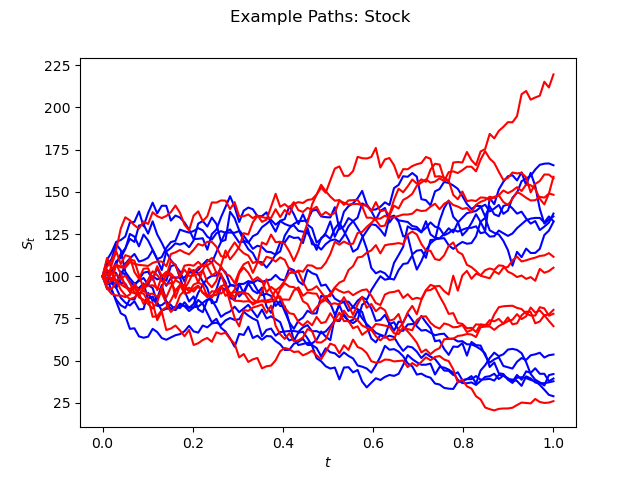

In [6]:
fig_s_paths, ax_s_paths = plt.subplots()
fig_s_paths.suptitle('Example Paths: Stock')
ax_s_paths.plot(h_te.time_grid, h_te.s_[:10, :].T, color='b', label='TE')
ax_s_paths.plot(h_qe.time_grid, h_qe.s_[:10, :].T, color='r', label='QE')
ax_s_paths.set_xlabel('$t$')
ax_s_paths.set_ylabel('$S_t$')
plt.show()

<IPython.core.display.Javascript object>


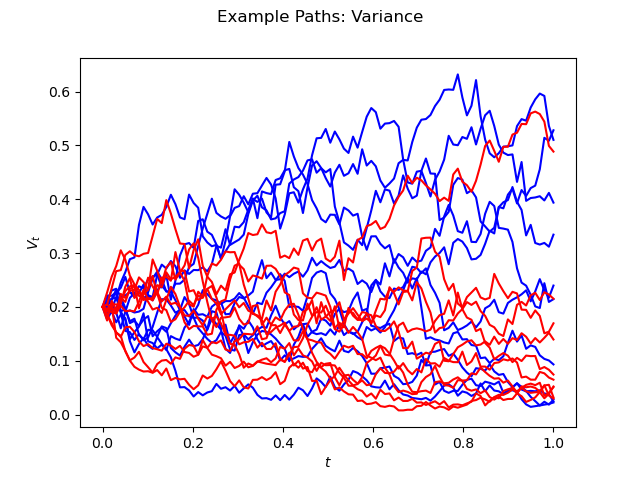

In [7]:
fig_v_paths, ax_v_paths = plt.subplots()
fig_v_paths.suptitle('Example Paths: Variance')
ax_v_paths.plot(h_te.time_grid, h_te.v_[:10, :].T, color='b', label='TE')
ax_v_paths.plot(h_qe.time_grid, h_qe.v_[:10, :].T, color='r', label='QE')
ax_v_paths.set_xlabel('$t$')
ax_v_paths.set_ylabel('$V_t$')
plt.show()

<IPython.core.display.Javascript object>


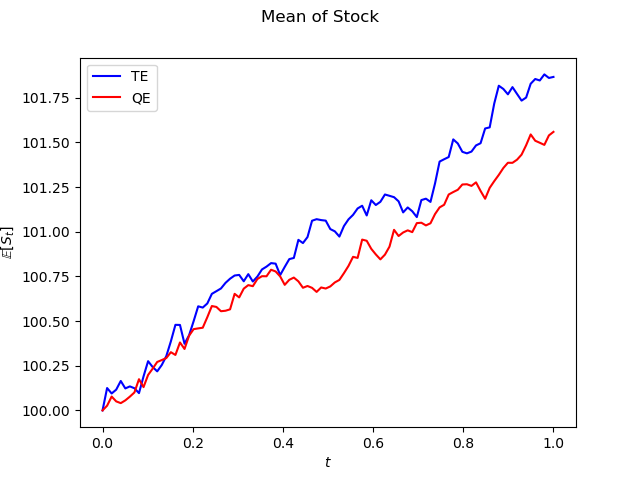

In [8]:
fig_s_mean, ax_s_mean = plt.subplots()
fig_s_mean.suptitle('Mean of Stock')
ax_s_mean.plot(h_te.time_grid, h_te.s_.mean(axis=0), color='b', label='TE')
ax_s_mean.plot(h_qe.time_grid, h_qe.s_.mean(axis=0), color='r', label='QE')
ax_s_mean.set_xlabel('$t$')
ax_s_mean.set_ylabel('$\mathbb{E}[S_t]$')
ax_s_mean.legend()
plt.show()

<IPython.core.display.Javascript object>


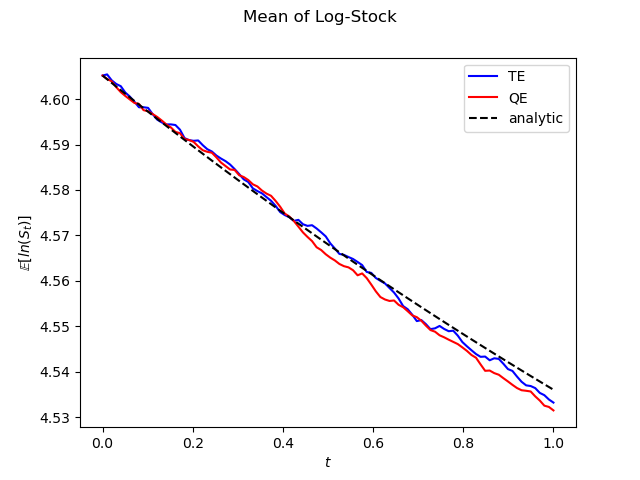

In [9]:
fig_log_s_mean, ax_log_s_mean = plt.subplots()
fig_log_s_mean.suptitle('Mean of Log-Stock')
ax_log_s_mean.plot(h_te.time_grid, np.log(h_te.s_).mean(axis=0), color='b', label='TE')
ax_log_s_mean.plot(h_qe.time_grid, np.log(h_qe.s_).mean(axis=0), color='r', label='QE')
ax_log_s_mean.plot(h_te.time_grid, h_te.analytic.s_log_mean(h_te.time_grid, np.log(h_te.s0)), color='k', linestyle='--', label='analytic')
ax_log_s_mean.set_xlabel('$t$')
ax_log_s_mean.set_ylabel('$\mathbb{E}[ln(S_t)]$')
ax_log_s_mean.legend()
plt.show()

<IPython.core.display.Javascript object>


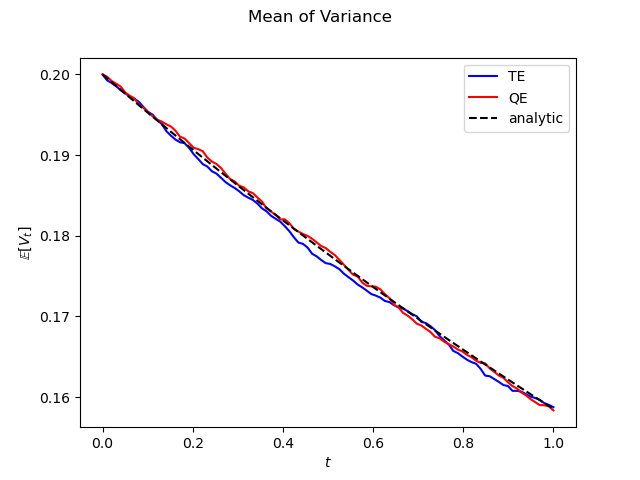

In [10]:
fig_v_mean, ax_v_mean = plt.subplots()
fig_v_mean.suptitle('Mean of Variance')
ax_v_mean.plot(h_te.time_grid, h_te.v_.mean(axis=0), color='b', label='TE')
ax_v_mean.plot(h_qe.time_grid, h_qe.v_.mean(axis=0), color='r', label='QE')
ax_v_mean.plot(h_te.time_grid, h_te.v_means(), color='k', linestyle='--', label='analytic')
ax_v_mean.set_xlabel('$t$')
ax_v_mean.set_ylabel('$\mathbb{E}[V_t]$')
ax_v_mean.legend()
plt.show()

<IPython.core.display.Javascript object>


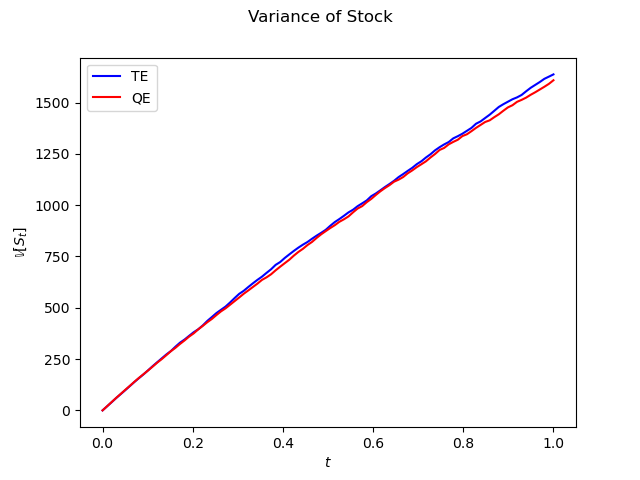

In [11]:
fig_s_var, ax_s_var = plt.subplots()
fig_s_var.suptitle('Variance of Stock')
ax_s_var.plot(h_te.time_grid, h_te.s_.var(axis=0), color='b', label='TE')
ax_s_var.plot(h_qe.time_grid, h_qe.s_.var(axis=0), color='r', label='QE')
ax_s_var.set_xlabel('$t$')
ax_s_var.set_ylabel('$\mathbb{V}[S_t]$')
ax_s_var.legend()
plt.show()

<IPython.core.display.Javascript object>


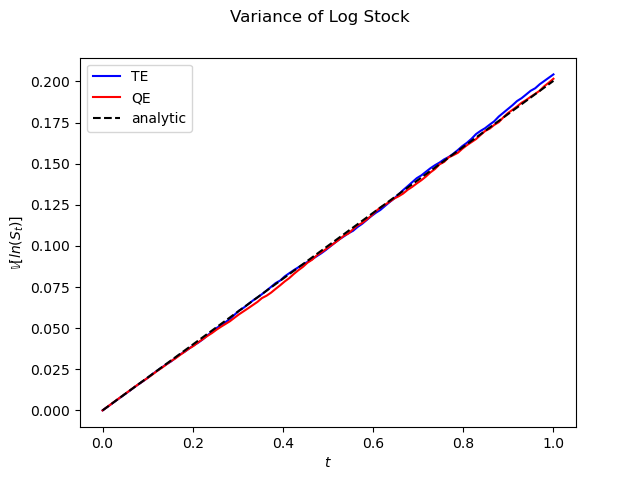

In [12]:
fig_s_log_var, ax_s_log_var = plt.subplots()
fig_s_log_var.suptitle('Variance of Log Stock')
ax_s_log_var.plot(h_te.time_grid, np.log(h_te.s_).var(axis=0), color='b', label='TE')
ax_s_log_var.plot(h_qe.time_grid, np.log(h_qe.s_).var(axis=0), color='r', label='QE')
ax_s_log_var.plot(h_te.time_grid, h_te.analytic.s_log_var(h_te.time_grid), color='k', linestyle='--', label='analytic')
ax_s_log_var.set_xlabel('$t$')
ax_s_log_var.set_ylabel('$\mathbb{V}[ln(S_t)]$')
ax_s_log_var.legend()
plt.show()

<IPython.core.display.Javascript object>


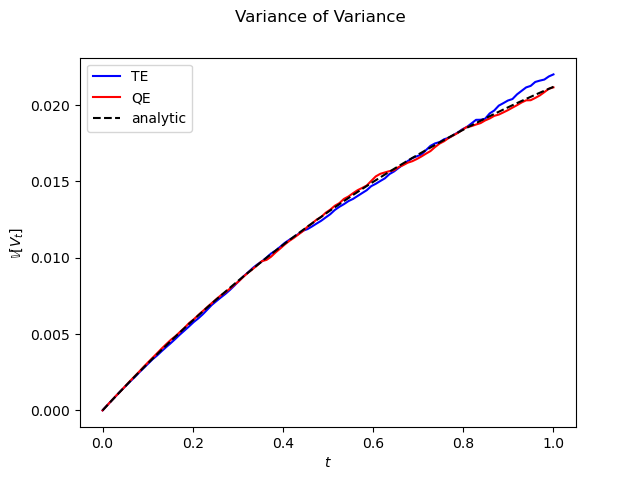

In [13]:
fig_v_var, ax_v_var = plt.subplots()
fig_v_var.suptitle('Variance of Variance')
ax_v_var.plot(h_te.time_grid, h_te.v_.var(axis=0), color='b', label='TE')
ax_v_var.plot(h_qe.time_grid, h_qe.v_.var(axis=0), color='r', label='QE')
ax_v_var.plot(h_te.time_grid, h_te.v_vars(), color='k', linestyle='--', label='analytic')
ax_v_var.set_xlabel('$t$')
ax_v_var.set_ylabel('$\mathbb{V}[V_t]$')
ax_v_var.legend()
plt.show()

<IPython.core.display.Javascript object>


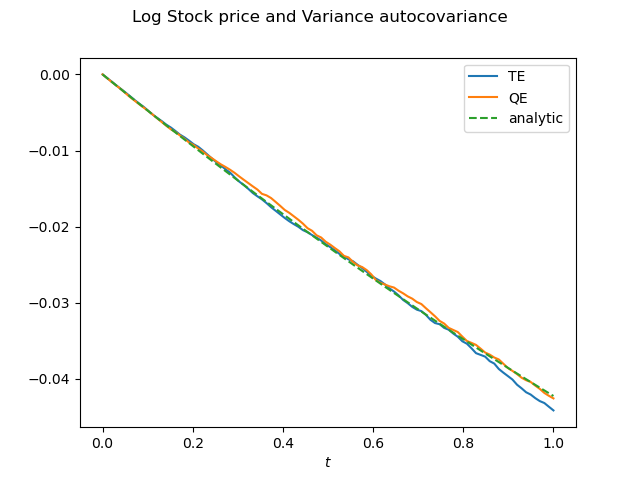

In [14]:
fig_log_s_v_cov,ax_log_s_v_cov = plt.subplots()
fig_log_s_v_cov.suptitle('Log Stock price and Variance autocovariance')
ax_log_s_v_cov.plot(h_te.time_grid, np.array([np.cov(np.log(h_te.s_[:, i]), h_te.v_[:, i])[0,1] for i in range(h_te.time_grid.shape[0]) ]) , label='TE')
ax_log_s_v_cov.plot(h_qe.time_grid, np.array([np.cov(np.log(h_qe.s_[:, i]), h_qe.v_[:, i])[0,1] for i in range(h_qe.time_grid.shape[0]) ]) , label='QE')
ax_log_s_v_cov.plot(h_te.time_grid, h_te.analytic.s_log_v_cov(h_te.time_grid) , label='analytic', linestyle='--')
ax_log_s_v_cov.set_xlabel('$t$')
ax_log_s_v_cov.legend()
plt.show()

# Option Pricing

## The Heston Characteristic Function

A key ingredient for option pricing in the Heston model is the Heston characteristic function. Recall that for any random variable $X$, the *characteristic function $\Psi_X: \mathbb{R} \to \mathbb{C}$ of $X$* is defined by
\begin{align*}
    \Psi_X(u) := \mathbb{E}[e^{i X u}].
\end{align*}
There are various slightly different formulations in the literature in how exactly to define the characteristic function for the Heston model. We follow the approach by Cui et al. and set $X := \ln(S_T/S_0)$. When pricing an option at $t$ that matures at $T$ and thus has time to maturity $\tau := T - t$, the expectation is taken with respect to $t$, i.e.
\begin{align*}
    \Psi(u) := \Psi_{\ln(S_T/S_0)} (u) := \mathbb{E}[e^{i \ln(S_T / S_0) u} \mid \mathcal{F}_t],
\end{align*}
where the process $S$ is given by the Heston SDE above. 

**Lemma:** The Heston characteristic function has the explicit representation
\begin{align*}
    \Psi(u) 
    &=\exp\Big(i u \ln\Big(\frac{F}{S_0}\Big) - \frac{\kappa \theta \rho \tau i u }{\sigma} - A + \frac{2 \kappa \theta}{\sigma^2} D \Big),
\end{align*}
where
\begin{align*}
    F & := S_t e^{(r-q)\tau}S_t, \\
    A & := \frac{A_1}{A_2}, \\
    A_1 & := (u^2 + iu) \sinh\Big(\frac{d \tau}{2}\Big) \\
    A_2 & := \frac{d}{v_0} \cosh\Big( \frac{d \tau}{2} \Big) + \frac{\xi}{v_0} \sinh\Big( \frac{d \tau}{2} \Big), \\
    d & := \sqrt{\xi^2 + \sigma^2 (u^2 + iu)}, \\
    \xi & := \kappa - \sigma \rho i u, \\
    D & := \ln\Big( \frac{d}{v_0} \Big) + \frac{\kappa - d}{2} \tau - \ln\Big( \frac{d + \xi}{2 v_0} + \frac{d-\xi}{2 v_0} e^{-d \tau} \Big)
\end{align*}

### Example

In [18]:
params = h.Params(v0=0.02, kappa=0.3, theta=0.04, sigma=0.4, rho=-0.6, r=0.03)
ha = h.Analytic(params)

In [19]:
u_grid = np.linspace(0, 5, 100)
psi_real = np.real(ha.characteristic_function(st=100, tau=5, u=u_grid))
psi_imag = np.imag(ha.characteristic_function(st=100, tau=5, u=u_grid))

<IPython.core.display.Javascript object>


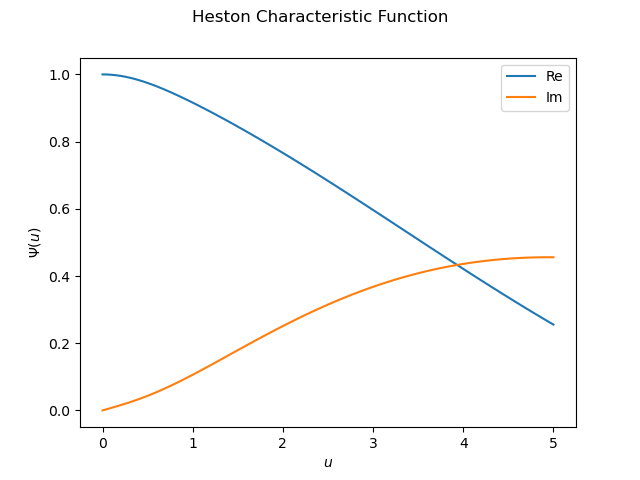

In [20]:
fig_char, ax_char = plt.subplots()
fig_char.suptitle('Heston Characteristic Function')
ax_char.plot(u_grid, psi_real, label='Re')
ax_char.plot(u_grid, psi_imag, label='Im')
ax_char.set_xlabel('$u$')
ax_char.set_ylabel('$\Psi(u)$')
ax_char.legend()
plt.show()

## Analytic Pricing

The importance of the characteristic function stems from the following.

**Theorem (Heston, 1993):** Let $S$ be a stock price following the Heston dynamics and $C=C(T,K)$ be a European call option on $S$ with maturity $T$ and strike $K$. Then
\begin{align}
    C_t = S_t e^{-q \tau} \Pi_1 - e^{-r \tau} K \Pi_2,
\end{align}
where $\tau := T -t$ and
\begin{align}
    \Pi_1 &:= \frac{1}{2} + \frac{1}{\pi}\int_0^{\infty}{\operatorname{Re}\Big( \frac{e^{-i u \ln(K/S_0)} \Psi(u-i)}{i u \Psi(-i)} \Big) du} \\
    \Pi_2 &:= \frac{1}{2} + \frac{1}{\pi} \int_0^{\infty}{\operatorname{Re}\Big( \frac{e^{-i u \ln(K/S_0)} \Psi(u)}{i u } \Big) du}
\end{align}

### Reformulation with Black-Scholes Control Variate
While this original formulation by Heston is quite nice for theoretical purposes, it poses some challenges in its implementation. The integrand can be highly oscillating and the upper bound is $\infty$. Thus, implementing this formula naively can result in numerical instabilities and thus prices can become inaccurate. There are alternative formulations that stabilize the integrand, see Le Floc'h 2018 for an overview. We use Eq. (18) therein that goes back to Andersen/Piterbarg2010, who introduce the Black-Scholes price as a control variate to arrive at
\begin{align*}
    C(T,K) = BS_{\text{call}}(T,K) + \frac{\sqrt{F K}e^{-rT}}{\pi} \int_0^{\infty}{\operatorname{Re}\Big( e^{-iux}\frac{\phi_B(u-\tfrac{i}{2}) - \phi(u-\tfrac{i}{2})}{u^2+\tfrac{1}{4}} \Big) du },
\end{align*}
where $BS_{\text{call}}(T,K)$ is the corresponding call option price in the Black-Scholes model with volatility $\sqrt{v_0}$, $\phi_B$ is the characteristic function of the normalized log-forward $\ln(F_T / F_0)$ in the Black-Scholes model and $\phi$ is the corresponding characteristic function in the Heston model and $x := \ln(\tfrac{F_t}{K})$. To price a put option, one only has to replace $BS_{\text{call}}(T,K)$ by $BS_{\text{put}}(T,K)$.

To connect this with the above formulation, the following is helpful.

**Theorem (Black-Scholes characteristic function):** In the Black-Scholes model $dS_t = (r-q)S_tdt + \sigma_{B}S_t dW_t$, the characteristic function of the normalized log forward is given by
\begin{align*}
    \phi_B(z) := \Psi_{\ln(F_T/F_0)}(z) = e^{-\tfrac{1}{2}\sigma_B^2 T(z^2+iz)}
\end{align*}

**Proof:** In the Black-Scholes model, we have
\begin{align*}
    F_T = S_T = S_0 \exp((r-q)T - \tfrac{1}{2} \sigma_B^2 T + \sigma W_T), && F_0 = S_0 e^{(r-q)T},
\end{align*}
hence
\begin{align*}
    \ln(F_T/F_0) = - \tfrac{1}{2} \sigma_B^2 T + \sigma W_T \sim - \tfrac{1}{2} \sigma_B^2 T + X,
\end{align*}
where $X \sim \mathcal{N}(0,\sigma_B^2 T)$. As the characteristic function of Gaussians is known, see for example [here](https://en.wikipedia.org/wiki/Characteristic_function_(probability_theory)#Examples), we obtain
\begin{align*}
    \phi_B(z) 
    = \mathbb{E}[e^{iz(- \tfrac{1}{2} \sigma_B^2 T + X)}]
    = \mathbb{E}[e^{iz X}] e^{- \tfrac{1}{2} \sigma_B^2 T}
    = e^{-\tfrac{1}{2}\sigma_B^2 T z^2} e^{- \tfrac{1}{2} \sigma_B^2 T i z}
    = e^{-\tfrac{1}{2} \sigma_B^2 T (z^2 + iz)}
\end{align*}

**Lemma:** The normalized log-stock Heston characteristic function $\Psi = \Psi_{\ln(S_T/S_0)}$ and the normalized log-forward Heston characteristic function $\phi=\Psi_{\ln(F_T/F_0)}$ are related by
\begin{align*}
    \phi(z) = \Psi(z) e^{-iz(r-q)T}.
\end{align*}

### Upper Bound for Integration
There are multiple approaches to tackle the problem that the upper bound of the integral is $\infty$, which obviously cannot be directly implemented. One approach by Andersen/Piterbarg is to truncate the integral. Based off the estimate
\begin{align*}
     \int_0^{\infty}{\Big| e^{-iux}\frac{\phi_B(u-\tfrac{i}{2}) - \phi(u-\tfrac{i}{2})}{u^2+\tfrac{1}{4}} \Big| du } \leq e^{-C_{\infty} u_{\max}} \int_{u_\max}^{\infty}{u^{-2}du}, &&
     C_{\infty} := \frac{v_0 + \kappa \vartheta T}{\sigma} \sqrt{1 - \rho^2}
\end{align*}
see also Le Floc'h Eq. (25), one can show that for a relative tolerance of $\varepsilon$, the truncation limit $u_{\max}$ satisfies
\begin{align*}
    -C_{\infty} u_{\max} - \ln(u_{\max}) = \ln(\varepsilon),
\end{align*}
which can be solved via Newton iteration. (In practice, this converges after only very few, e.g. $3$, steps.) 
For very small maturities, it turns out to better use
\begin{align*}
    - \frac{1}{2} v_0 T \hat u_{\max}^2 - \ln(\hat u_{\max}) = \ln(\varepsilon),
\end{align*}
see Le Floc'h Eq. (28). One can simply use both calculations and then use $\max(u_{\max},\hat u_{\max})+1$ as a truncation limit.

In [29]:
with open(r'heston_params.pickle', 'rb') as handle:
    params = pickle.load(handle)
df = pd.read_pickle('heston_df_prices.pickle')

In [30]:
params_ui = {k:v for k,v in params.items() if k in ['v0', 'kappa', 'theta', 'sigma', 'rho', 'pc'] }
def params_dict_to_ui(pdict):
    psliders = []
    for k, v in pdict.items():
        intsl = wd.IntSlider(min=0, max=v.shape[0]-1, description=k, readout=False)
        intlbl = wd.Label('%.2f' % pdict[k][0])
        psliders.append(wd.HBox([intsl, intlbl]))
    return wd.VBox(psliders)
    
pui = params_dict_to_ui(params_ui)

<IPython.core.display.Javascript object>


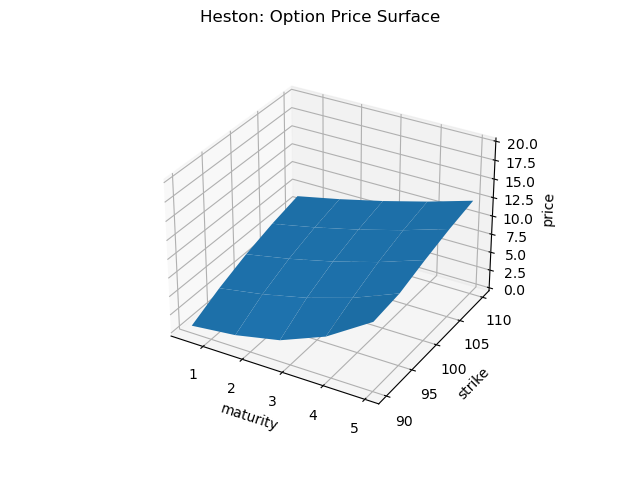

In [32]:
fig_options = plt.figure()
fig_options.suptitle('Heston: Option Price Surface')
ax_options = plt.axes(projection="3d")

def update_surface_plot():
    ax_options.clear()
    df_surface = df.query('&'.join([child.children[0].description+'_id' + '=='+ str(child.children[0].value) for child in pui.children]))
    tm_ids = df_surface['tm_id'].unique()
    sk_ids = df_surface['sk_id'].unique()
    prices = np.array([[ df_surface[(df_surface['tm_id']==tm_id) & (df_surface['sk_id']==sk_id)]['price'].values[0] for sk_id in sk_ids] for tm_id in tm_ids])    
    maturities_, strikes_ = np.meshgrid(params['tm'], params['sk']) 
    ax_options.plot_surface(maturities_, strikes_, prices)
    ax_options.set_xlabel('maturity')
    ax_options.set_ylabel('strike')
    ax_options.set_zlabel('price')
    ax_options.set_zlim([0, 20])
    plt.show()

for sliders in pui.children:
    intsl, intlbl = sliders.children
    def conv_val(c, sl=intsl, lbl=intlbl):
        lbl.value = '%.2f' % params[sl.description][sl.value]
        update_surface_plot()
    intsl.observe(conv_val, names='value')
    
display(pui)
update_surface_plot()

## Monte Carlo pricing

Alternatively, European call and put options can be valued via Monte Carlo simulation. Having simulated the stock price as $\hat S_t$, we obtain a simulated option price via
\begin{align*}
    \hat C_0 = e^{-rT}\mathbb{E}[(\hat S_T - K)^+] &&
    \hat P_0 = e^{-rT}\mathbb{E}[(K - \hat S_T)^+]
\end{align*}

In [33]:
strikes = np.linspace(90, 110, 10)
ti = round(h_qe.time_grid.shape[0] / 2)
maturities = h_qe.time_grid[ti:]
strikes_, maturities_ = np.meshgrid(strikes, maturities)
call_analytic = np.array([[h_qe.analytic.price_option(tau, k, h_qe.s0, 'c') for k in strikes] for tau in maturities])
put_analytic = np.array([[h_qe.analytic.price_option(tau, k, h_qe.s0, 'p') for k in strikes] for tau in maturities])
call_mc = np.array([[h_qe.price_option(0, t, k, 'c').mean() for k in strikes] for t in range(ti, h_qe.time_grid.shape[0])])
put_mc = np.array([[h_qe.price_option(0, t, k, 'p').mean() for k in strikes] for t in range(ti, h_qe.time_grid.shape[0])])

<IPython.core.display.Javascript object>


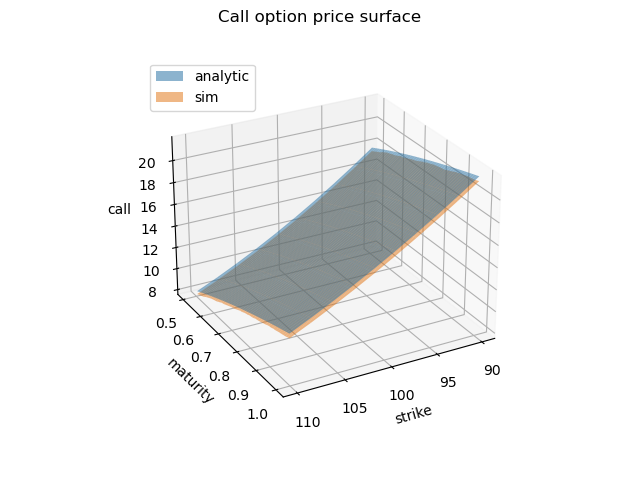

In [34]:
tx, ty = np.meshgrid(h_qe.time_grid[1:], h_qe.time_grid[1:])
figcall = plt.figure()
figcall.suptitle('Call option price surface')
axcall = plt.axes(projection="3d")
surf = axcall.plot_surface(strikes_, maturities_, call_analytic, label='analytic', alpha=0.5)
surf._facecolors2d = surf._facecolor3d
surf._edgecolors2d = surf._edgecolor3d
surf = axcall.plot_surface(strikes_, maturities_, call_mc, label='sim', alpha=0.5)
surf._facecolors2d = surf._facecolor3d
surf._edgecolors2d = surf._edgecolor3d
axcall.set_xlabel('strike')
axcall.set_ylabel('maturity')
axcall.set_zlabel('call')
axcall.legend(loc='upper left')
plt.show()

<IPython.core.display.Javascript object>


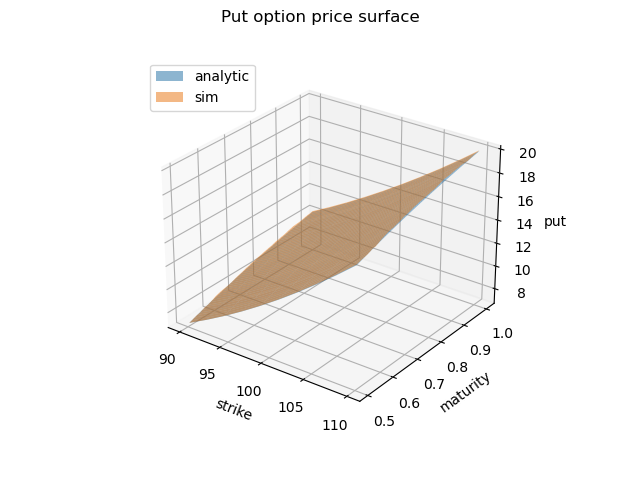

In [36]:
tx, ty = np.meshgrid(h_qe.time_grid[1:], h_qe.time_grid[1:])
figput = plt.figure()
figput.suptitle('Put option price surface')
axput = plt.axes(projection="3d")
surf = axput.plot_surface(strikes_, maturities_, put_analytic, label='analytic', alpha=0.5)
surf._facecolors2d = surf._facecolor3d
surf._edgecolors2d = surf._edgecolor3d
surf = axput.plot_surface(strikes_, maturities_, put_mc, label='sim', alpha=0.5)
surf._facecolors2d = surf._facecolor3d
surf._edgecolors2d = surf._edgecolor3d
axput.set_xlabel('strike')
axput.set_ylabel('maturity')
axput.set_zlabel('put')
axput.legend(loc='upper left')
plt.show()

# References

* Andersen. *Efficient Simulation of the Heston Stochastic Volatility Model*, SSRN 2007, http://ssrn.com/abstract=946405
* Cui et al. *Full and fast calibration of the Heston stochastic volatility model*, European Journal of Operational Research
Volume 263, Issue 2, 1 December 2017, Pages 625-638*, https://doi.org/10.1016/j.ejor.2017.05.018
* Le Floc'h. *An adaptive Filon quadrature for stochastic volatility models*, SSRN 2018, https://ssrn.com/abstract=3304016
* Heston, *A Closed-Form Solution for Options with Stochastic Volatility with Applications to Bond and Currency Options*, Review of Financial Studies, 1993, Vol. 6. number 2, pp. 327-343, 